In [1]:
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
import os
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
# from torch.distributions import Normal, kl_divergence
from torchsummary import summary
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
image_dir = "C:/Users/Gert/repos/AML-exam-project/project/mvtec_anomaly_detection/carpet/train/"
transform_non_normal = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])
dataset_non_normal = ImageFolder(root=image_dir, transform=transform_non_normal)
dataloader = DataLoader(dataset_non_normal, batch_size=8, shuffle=True)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [4]:
class AE(nn.Module):
    def __init__(self, input_channels=3, latent_dim=128):
        super(AE, self).__init__()

        # Encoder: Convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0),

        )

        self.encoder_bottleneck = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=2, stride=2, padding=0),      # 64x64x64 -> 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=0),      # 32x32x32 -> 32x16x16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=2, stride=2, padding=0),      # 32x16x16 -> 32x8x8
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, stride=1, padding=1),      # 32x8x8 -> 16x8x8
            nn.BatchNorm2d(16),
            nn.ReLU(),   # Bottleneck


            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),   # 16x8x8 -> 32x8x8
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0, output_padding=0),   # 32x8x8 -> 32x16x16
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=0, output_padding=0),   # 32x16x16 -> 32x32x32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2, padding=0, output_padding=0),   # 32x32x32 -> 64x64x64
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(

            nn.ConvTranspose2d(64, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 128x64x64 -> 128x128x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # 128x128x128 -> 128x128x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # 128x128x128 -> 128x128x128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),

            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1), # 128x128x128 -> 128x256x256
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # 128x256x256 -> 128x256x256
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),  # 128x256x256 -> 128x256x256
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 128x256x256 -> 64x512x512
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),    # 64x512x512 -> 64x512x512
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),    # 64x512x512 -> 64x512x512
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(p=0.2),

            nn.Conv2d(64, 3, kernel_size=1),               # 64x512x512 -> 3x512x512
            nn.Sigmoid()  
        )

    def encode(self, x):
        x = self.encoder(x)
        return x

    def decode(self, z):
        x = self.decoder(z)
        return x
    
    def bottleneck(self, x):
        z = self.encoder_bottleneck(x)
        return z

    def forward(self, x):
        x = self.encode(x)
        x = self.bottleneck(x)
        reconstructed = self.decode(x)
        return reconstructed

In [5]:
def ae_loss(reconstructed, original):
    # Reconstruction loss (e.g., MSE)
    recon_loss = F.mse_loss(reconstructed, original, reduction="sum")
    return recon_loss

In [6]:
model = AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [7]:
summary(model, (3,512,512), batch_size=8, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 512, 512]           1,792
       BatchNorm2d-2          [8, 64, 512, 512]             128
              ReLU-3          [8, 64, 512, 512]               0
         Dropout2d-4          [8, 64, 512, 512]               0
            Conv2d-5          [8, 64, 512, 512]          36,928
       BatchNorm2d-6          [8, 64, 512, 512]             128
              ReLU-7          [8, 64, 512, 512]               0
         Dropout2d-8          [8, 64, 512, 512]               0
         MaxPool2d-9          [8, 64, 256, 256]               0
           Conv2d-10         [8, 128, 256, 256]          73,856
      BatchNorm2d-11         [8, 128, 256, 256]             256
             ReLU-12         [8, 128, 256, 256]               0
        Dropout2d-13         [8, 128, 256, 256]               0
           Conv2d-14         [8, 128, 2

In [8]:
def save_checkpoint(model, optimizer, epoch, file_path, losses):
    """
    Save the training state to a checkpoint file.

    Args:
        model: PyTorch model to save.
        optimizer: Optimizer used in training.
        epoch: Current epoch.
        file_path: Path to save the checkpoint.
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'epoch': epoch,
        'losses': losses
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved at {file_path}")

Epoch [10/100], Loss: 14690.5992


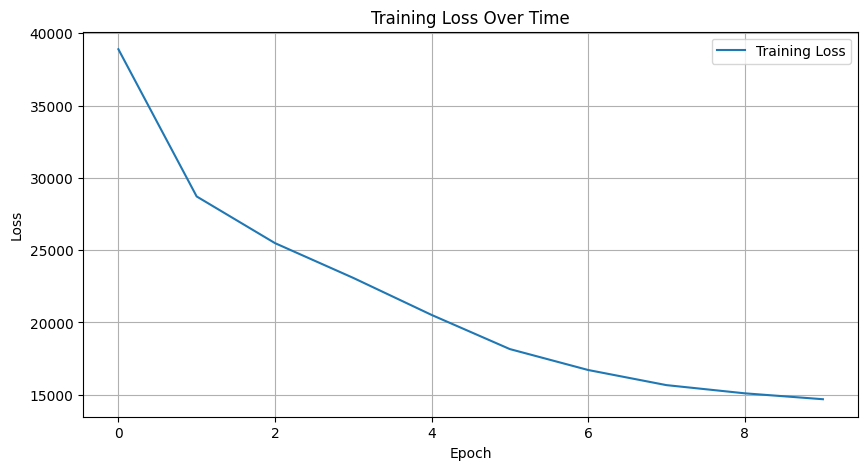

Checkpoint saved at C:/Users/Gert/repos/AML-exam-project/project/models/autoencoder_Ver7_10_epochs_checkpoint.pth


KeyboardInterrupt: 

In [9]:
# Training

losses = []
epochs = 100
for epoch in range(epochs):
    model.train()
    train_loss = 0
    count = 0
    for images, _ in dataloader:
        images = images.to(device)
        
        # Forward pass
        reconstructed = model(images)
        
        loss = ae_loss(reconstructed, images)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        count += 1
        print(f"Batch Count: {count}")

    epoch_loss = round(train_loss / len(dataloader.dataset), 4)
    clear_output(wait=True)  # Clear the previous plot
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss}")
    losses.append(epoch_loss)
    plt.figure(figsize=(10, 5))
    plt.plot(losses, label="Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.grid(True)
    plt.show()

    if (epoch+1) % 10 == 0:
        save_checkpoint(model, optimizer, epoch, f"C:/Users/Gert/repos/AML-exam-project/project/models/autoencoder_Ver7_{epoch+1}_epochs_checkpoint.pth", losses)
